In [7]:
import yfinance as yf
import pandas as pd

# Download data from Yahoo Finance
eth = yf.download('ETH-USD', start='2020-01-01', end=None, interval='1d')

# Keep required columns
eth = eth[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
eth.index.name = 'Date'

# Add market cap approximation (price * volume, just for illustrative purposes)
eth['Market Cap'] = eth['Close'] * eth['Volume']

# Save metadata
data_source = "Yahoo Finance"
date_range = f"{eth.index.min().date()} to {eth.index.max().date()}"


[*********************100%***********************]  1 of 1 completed


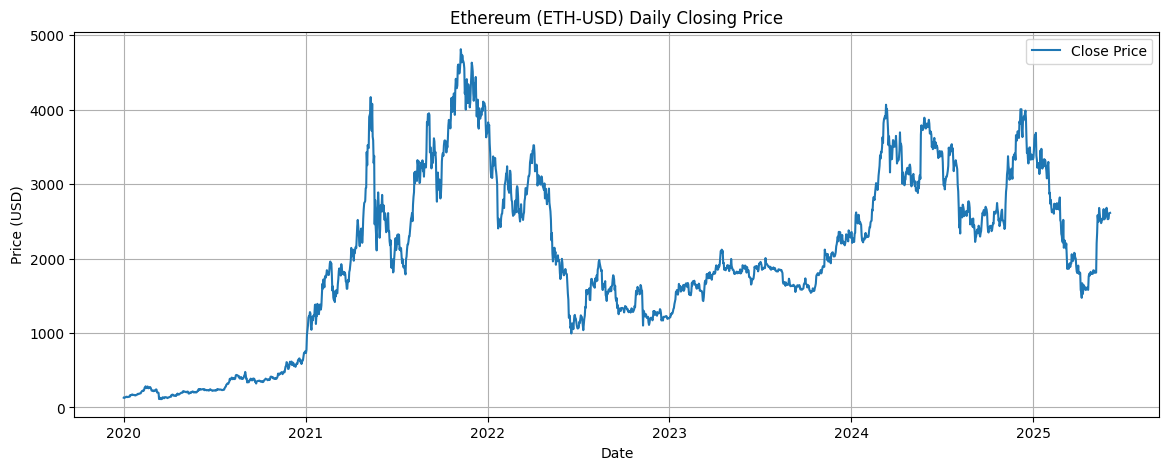

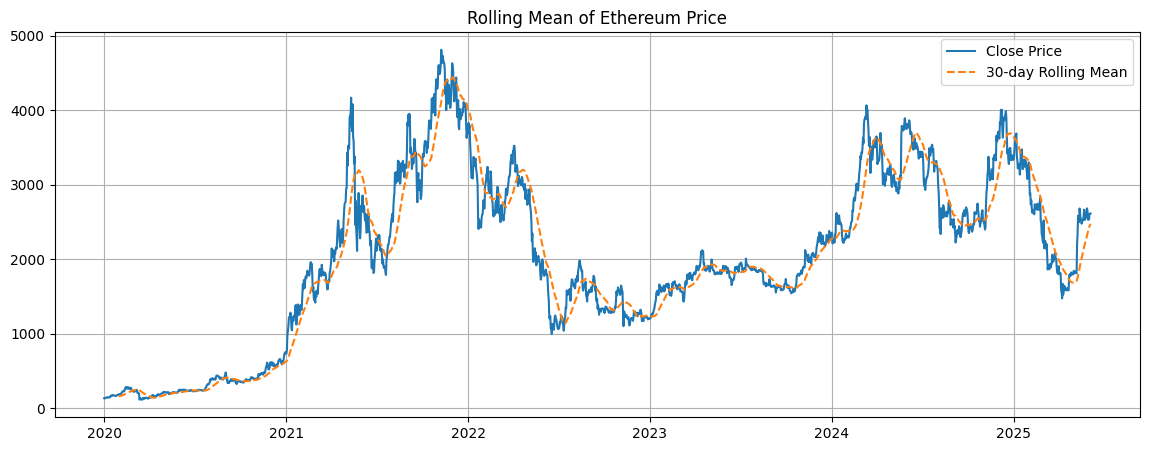

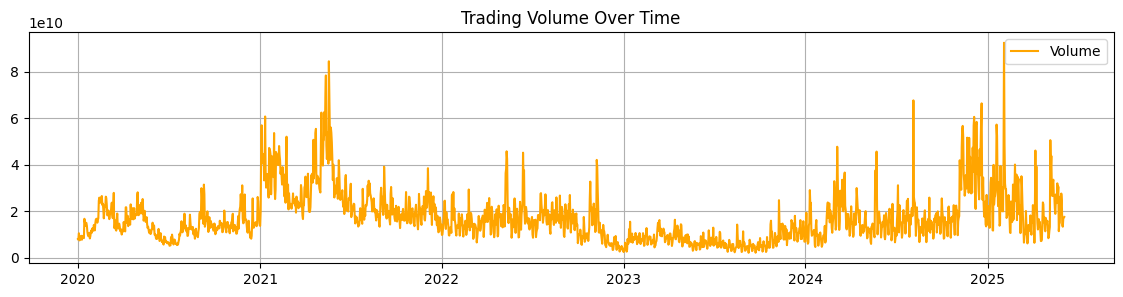

Price          Open         High          Low        Close        Volume  \
Ticker      ETH-USD      ETH-USD      ETH-USD      ETH-USD       ETH-USD   
count   1981.000000  1981.000000  1981.000000  1981.000000  1.981000e+03   
mean    2015.202576  2069.489934  1955.735406  2016.278246  1.711292e+10   
std     1121.441865  1151.623138  1086.605798  1120.390131  1.071889e+10   
min      110.406784   116.021622    95.184303   110.605873  2.081626e+09   
25%     1310.563110  1339.744751  1271.150879  1311.644409  9.802443e+09   
50%     1893.053589  1936.453735  1859.568848  1893.078125  1.495405e+10   
75%     2881.296875  2954.556641  2764.010498  2881.481934  2.125336e+10   
max     4810.071289  4891.704590  4718.039062  4812.087402  9.245355e+10   

Price     Market Cap Rolling Mean  
Ticker                             
count   1.981000e+03  1952.000000  
mean    3.785776e+13  2026.097941  
std     3.741326e+13  1096.832614  
min     1.003688e+12   136.959600  
25%     9.361490e+12  1

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot of closing price
plt.figure(figsize=(14, 5))
plt.plot(eth['Close'], label='Close Price')
plt.title('Ethereum (ETH-USD) Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 30-day rolling average
eth['Rolling Mean'] = eth['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 5))
plt.plot(eth['Close'], label='Close Price')
plt.plot(eth['Rolling Mean'], label='30-day Rolling Mean', linestyle='--')
plt.title('Rolling Mean of Ethereum Price')
plt.legend()
plt.grid(True)
plt.show()

# Volume trend
plt.figure(figsize=(14, 3))
plt.plot(eth['Volume'], color='orange', label='Volume')
plt.title('Trading Volume Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Summary statistics
print(eth.describe())


In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(eth['Close'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If not stationary, difference it
eth['Close_diff'] = eth['Close'].diff().dropna()

# Test differenced series
result_diff = adfuller(eth['Close_diff'].dropna())
print(f"Differenced ADF Statistic: {result_diff[0]}")
print(f"Differenced p-value: {result_diff[1]}")


ADF Statistic: -2.2293433400171745
p-value: 0.19576837876427822
Differenced ADF Statistic: -17.495365340995487
Differenced p-value: 4.4143835420817526e-30


<Figure size 1200x400 with 0 Axes>

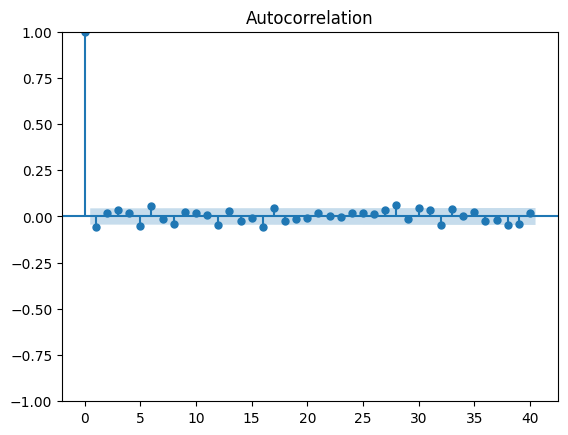

<Figure size 1200x400 with 0 Axes>

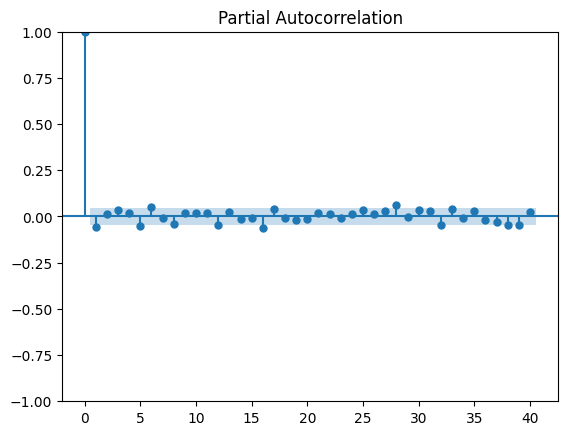

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plot_acf(eth['Close_diff'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(eth['Close_diff'].dropna(), lags=40)
plt.show()


In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(eth['Close'], order=(2, 1, 2))  # Replace with your actual (p,d,q)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1981
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11783.038
Date:                Wed, 04 Jun 2025   AIC                          23576.076
Time:                        01:39:38   BIC                          23604.030
Sample:                             0   HQIC                         23586.345
                               - 1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2593      0.007    -39.154      0.000      -0.272      -0.246
ar.L2         -0.9646      0.007   -131.488      0.000      -0.979      -0.950
ma.L1          0.2408      0.005     51.102      0.0

In [12]:
# Predict on training data
eth['Predicted'] = model_fit.predict(start=eth.index[1], end=eth.index[-1])

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(eth['Close'][1:], eth['Predicted'][1:]))
mape = mean_absolute_percentage_error(eth['Close'][1:], eth['Predicted'][1:])
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


RMSE: 92.91874837155122
MAPE: 0.029821440238220604


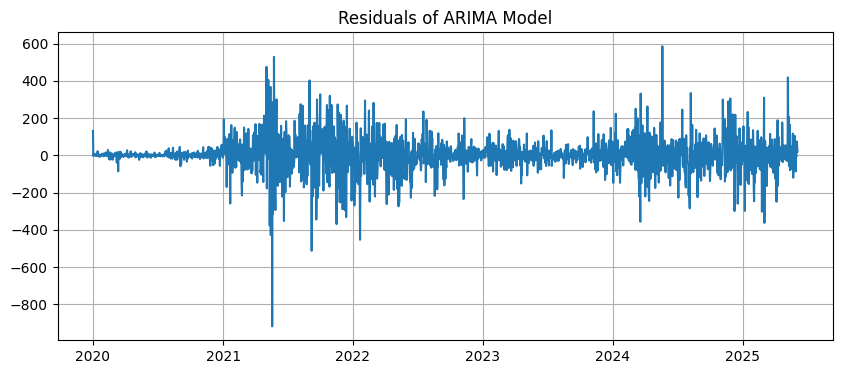

In [13]:
residuals = model_fit.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.grid(True)
plt.show()


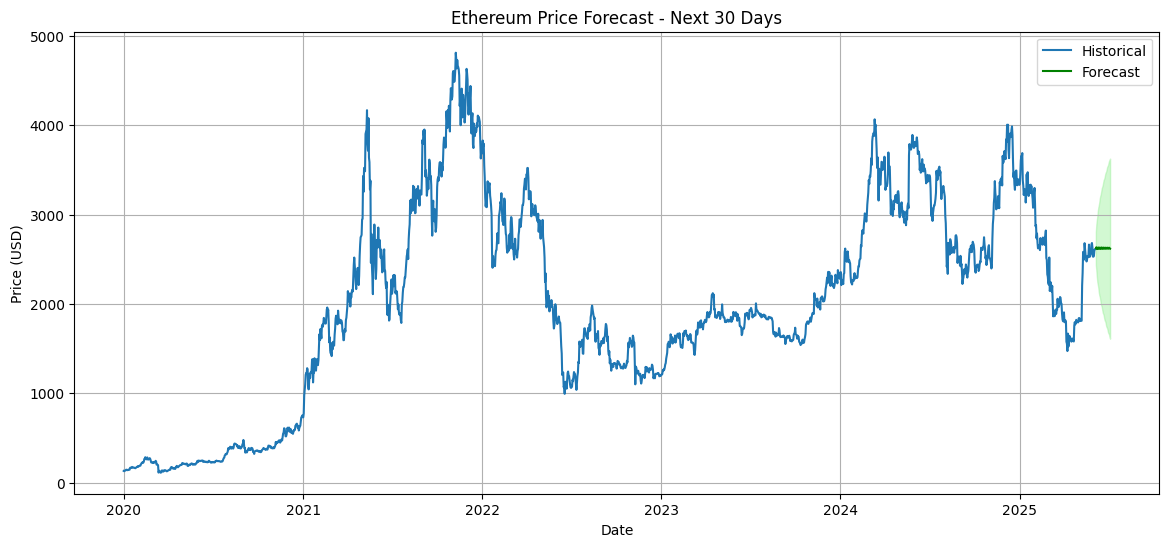

In [15]:
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

future_dates = pd.date_range(eth.index[-1], periods=forecast_steps+1, freq='D')[1:]
forecast_mean.index = future_dates
forecast_ci.index = future_dates

# Plot
plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Historical')
plt.plot(forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.4)
plt.title('Ethereum Price Forecast - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Combine forecast results into a DataFrame
forecast_table = pd.DataFrame({
    'Date': forecast_mean.index,
    'Forecasted Price (USD)': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
})

# Round for better readability
forecast_table = forecast_table.round(2)

# Display the first few forecasted values
print(forecast_table.head(10))  # Show top 10 rows


                 Date  Forecasted Price (USD)  Lower CI  Upper CI
2025-06-05 2025-06-05                 2622.84   2439.53   2806.16
2025-06-06 2025-06-06                 2633.86   2377.00   2890.72
2025-06-07 2025-06-07                 2622.35   2305.40   2939.31
2025-06-08 2025-06-08                 2614.71   2246.46   2982.96
2025-06-09 2025-06-09                 2627.79   2217.27   3038.31
2025-06-10 2025-06-10                 2631.77   2183.00   3080.54
2025-06-11 2025-06-11                 2618.12   2131.89   3104.35
2025-06-12 2025-06-12                 2617.82   2097.31   3138.33
2025-06-13 2025-06-13                 2631.07   2080.15   3181.98
2025-06-14 2025-06-14                 2627.92   2047.35   3208.49
